In [1]:
import torch
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt
import pickle

In [2]:
alexnet = models.alexnet(pretrained=True)

Let us look at AlexNet.

https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [3]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
aln_conv1 = alexnet.features[0].weight[:].detach().numpy()
print("aln_conv1", aln_conv1.shape)
aln_conv2 = alexnet.features[3].weight[:].detach().numpy()
print("aln_conv2", aln_conv2.shape)
aln_conv3 = alexnet.features[6].weight[:].detach().numpy()
print("aln_conv3", aln_conv3.shape)
aln_conv4 = alexnet.features[8].weight[:].detach().numpy()
print("aln_conv4", aln_conv4.shape)
aln_conv5 = alexnet.features[10].weight[:].detach().numpy()
print("aln_conv5", aln_conv5.shape)
aln_lin_1 = alexnet.classifier[1].weight[:].detach().numpy()
print("aln_lin_1", aln_lin_1.shape)
aln_lin_2 = alexnet.classifier[4].weight[:].detach().numpy()
print("aln_lin_2", aln_lin_2.shape)
aln_lin_3 = alexnet.classifier[6].weight[:].detach().numpy()
print("aln_lin_3", aln_lin_3.shape)


aln_conv1 (64, 3, 11, 11)
aln_conv2 (192, 64, 5, 5)
aln_conv3 (384, 192, 3, 3)
aln_conv4 (256, 384, 3, 3)
aln_conv5 (256, 256, 3, 3)
aln_lin_1 (4096, 9216)
aln_lin_2 (4096, 4096)
aln_lin_3 (1000, 4096)


In [5]:
from analyze_model import Plot2DMatrix, PlotVectorSizes

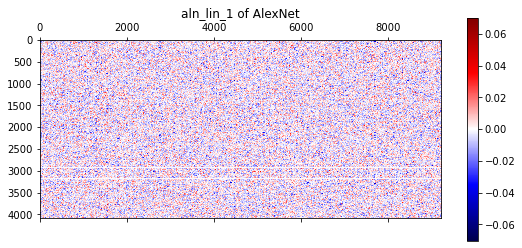

100%|██████████| 4096/4096 [01:16<00:00, 53.35it/s]


There are totally 0 zero elements in this matrix, percentage is 0.0


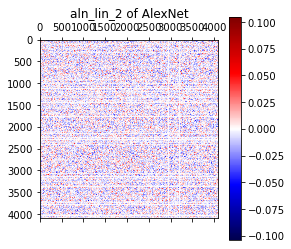

100%|██████████| 4096/4096 [00:34<00:00, 120.44it/s]


There are totally 0 zero elements in this matrix, percentage is 0.0


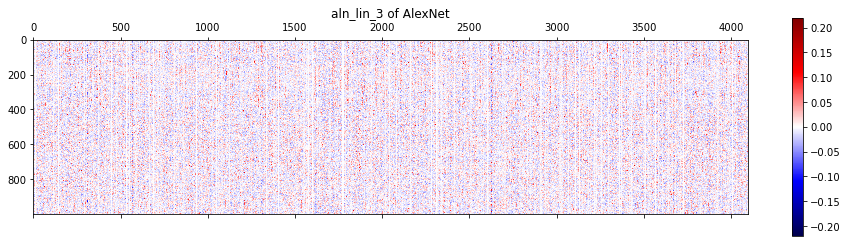

100%|██████████| 1000/1000 [00:08<00:00, 118.94it/s]

There are totally 0 zero elements in this matrix, percentage is 0.0


In [7]:
Plot2DMatrix(aln_lin_1, "aln_lin_1 of AlexNet", color_map="seismic")
Plot2DMatrix(aln_lin_2, "aln_lin_2 of AlexNet", color_map="seismic")
Plot2DMatrix(aln_lin_3, "aln_lin_3 of AlexNet", color_map="seismic")

Now, let us do some pruning on the fully connected layer.

In [9]:
import torch.nn.utils.prune as prune

## layer-wise pruning
# prune.random_unstructured(alexnet.classifier[1], name="weight", amount=0.3)
# prune.random_unstructured(alexnet.classifier[4], name="weight", amount=0.3)
# prune.random_unstructured(alexnet.classifier[6], name="weight", amount=0.3)

## global pruning
parameters_to_prune = (
    (alexnet.classifier[1], 'weight'),
    (alexnet.classifier[4], 'weight'),
    (alexnet.classifier[6], 'weight'),
)

# Here we compress the model by 80%, other compression rates also apply as a input parameter.
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.8,
)

print(
    "Sparsity in fullyconnected_1.weight: {:.2f}%".format(
        100. * float(torch.sum(alexnet.classifier[1].weight == 0))
        / float(alexnet.classifier[1].weight.nelement())
    )
)
print(
    "Sparsity in fullyconnected_2.weight: {:.2f}%".format(
        100. * float(torch.sum(alexnet.classifier[4].weight == 0))
        / float(alexnet.classifier[4].weight.nelement())
    )
)
print(
    "Sparsity in fullyconnected_3.weight: {:.2f}%".format(
        100. * float(torch.sum(alexnet.classifier[6].weight == 0))
        / float(alexnet.classifier[6].weight.nelement())
    )
)

Sparsity in fullyconnected_1.weight: 84.58%
Sparsity in fullyconnected_2.weight: 74.90%
Sparsity in fullyconnected_3.weight: 58.66%


In [10]:
compressed_aln_lin_1 = alexnet.classifier[1].weight[:].detach().numpy()
print("compressed_aln_lin_1", compressed_aln_lin_1.shape)
compressed_aln_lin_2 = alexnet.classifier[4].weight[:].detach().numpy()
print("compressed_aln_lin_2", compressed_aln_lin_2.shape)
compressed_aln_lin_3 = alexnet.classifier[6].weight[:].detach().numpy()
print("compressed_aln_lin_3", compressed_aln_lin_3.shape)

compressed_aln_lin_1 (4096, 9216)
compressed_aln_lin_2 (4096, 4096)
compressed_aln_lin_3 (1000, 4096)


100%|██████████| 1000/1000 [00:08<00:00, 119.73it/s]


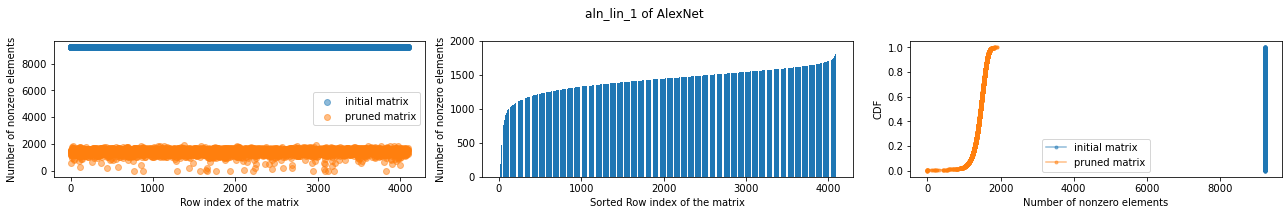

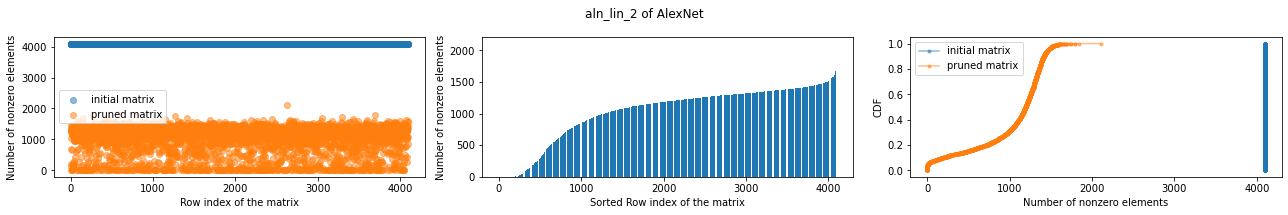

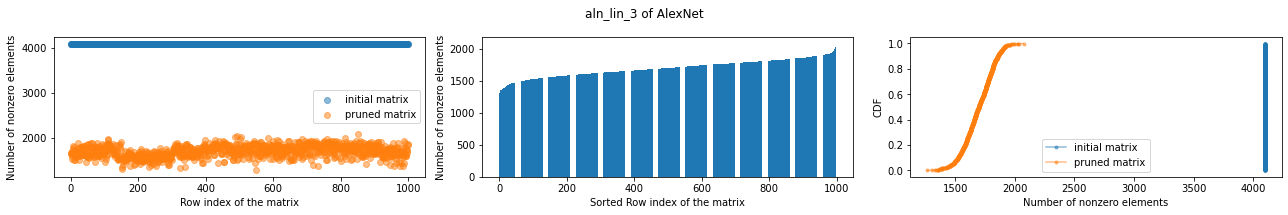

In [11]:
PlotVectorSizes(aln_lin_1, compressed_aln_lin_1, "aln_lin_1 of AlexNet", plot_two_matrces=True)
PlotVectorSizes(aln_lin_2, compressed_aln_lin_2, "aln_lin_2 of AlexNet", plot_two_matrces=True)
PlotVectorSizes(aln_lin_3, compressed_aln_lin_3, "aln_lin_3 of AlexNet", plot_two_matrces=True)

In [12]:
pickle.dump(aln_lin_1, open("../../data/saved_models/alexnet/aln_lin_1.p", "wb"))
pickle.dump(aln_lin_2, open("../../data/saved_models/alexnet/aln_lin_2.p", "wb"))
pickle.dump(aln_lin_3, open("../../data/saved_models/alexnet/aln_lin_3.p", "wb"))
pickle.dump(compressed_aln_lin_1, open("../../data/saved_models/alexnet/compressed_80_aln_lin_1.p", "wb"))
pickle.dump(compressed_aln_lin_2, open("../../data/saved_models/alexnet/compressed_80_aln_lin_2.p", "wb"))
pickle.dump(compressed_aln_lin_3, open("../../data/saved_models/alexnet/compressed_80_aln_lin_3.p", "wb"))

print("model saved in pickle files")

model saved in pickle files


Now, let us try some scheduling algorithms.